# Анализ оттока посетителей фитнес-клуба.

**Цель проекта.**

С помощью данных множется клиентских анкет посетителей клуба мы проанализируем отток клиентов клуба, выявим основные признаки, наиболее сильно влияющие на отток, спрогнозируем вероятность ухода клиентов в будущем с помощью методов машинного обучения, а также классифицируем клиентов по группам схожего поведения.
Все это поможет найти индивидальный подход к особенностям поведения каждого клиента и сформировать стратегию по удержанию клиентов на максимальный срок.

## Содержание. 
1. [Загрузка данных](#paragraph1)
2. [Иследовательский анализ данных](#paragraph2)
3. [Матрица корреляций признаков](#paragraph3)
4. [Построение модели прогнозирования оттока клиентов](#paragraph4)
5. [Кластеризация клиентов](#paragraph5) 
6. [Выводы](#paragraph6) 

In [1]:
import pandas as  pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

## Загрузка данных <a name="paragraph1"></a>

In [2]:
data = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


В данной задаче будем использовать метод обучения с учителем, поскольку целевая переменная у нас есть, и с бинарной классификацией, т.к. целевая переменная принимает два значения: ушел клиент или остался.

## Исследовательский анализ данных (EDA) <a name="paragraph2"></a>

Изучим основную информацию о предоставленных данных. 

In [4]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Проверка на дубликаты.**

In [9]:
print('Количество дубликатов в данных:', data.duplicated().sum())

Количество дубликатов в данных: 0


По средним значениям, полученным выше, можно составить портрет среднестатистического клиента. С примено равной вероятностью это может быть и мужчина, и женщина, 29 лет, клиент живет довольно близко к клубу, с абонементом на 5 месяцев.
С момента первого посещения прошло 4 месяца, групповые занятия скорее не посещает, в зал ходит в среднем около 2х раз в неделю, на доп. услуги тратит около 147 денежных единиц.



Всего в наборе данных 4 тысячи наблюдений, 13 признаков и одна целевая переменная, отсуствующих признаков нет. Признаки как числовые, так и категориальные. Такого количества достаточно для анализа и прогнозирования.
Важно отметить, что количественные признаки имеют разную размерность (например, возраст и траты на доп. услуги клуба). Это потребует стандартизации признаков перед обучением моделей машинного обучения для того, чтобы избежать перевеса некоторых из них.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [5]:
data.groupby('Churn').mean().T

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


Исходя из из средних значений признаков можно наметить признаки, которые имеют наибольшее влияние на факт оттока. 

Так, например **пол**, не имеет влияния на факт оттока. И мужчины, и женщины примерно с одинаковой частотой покидают клуб. Также *не имеют влияния* такие признаки как: начилие телефона, посещение групповых тренировок, возраст.

Признаки, которые вероятнее всего влияют на удержание: клиенты от партнеров клуба и клиенты, пришедшие по рекомендациям друзей. Прежде всего потому, что это дает скидки. Также длительность абонемента, длительность посещений.
Средние значение не дают полного понимания картины. Посмотрим на распределения. 

### Cтолбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

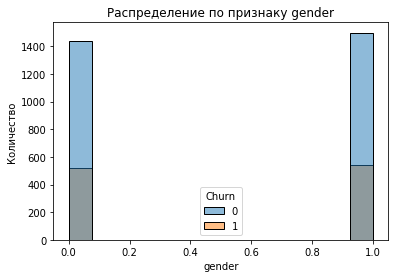

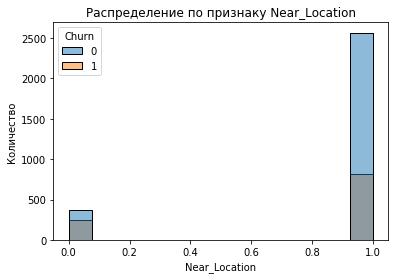

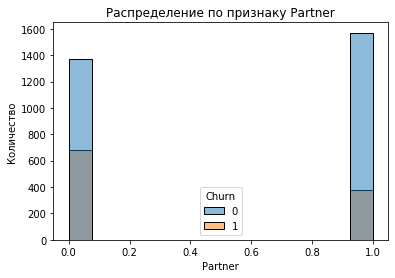

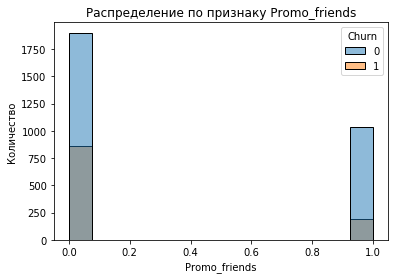

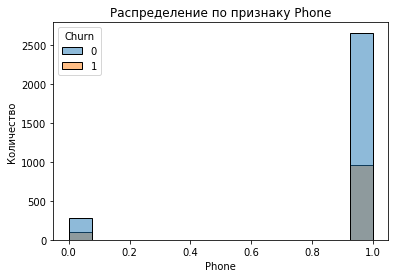

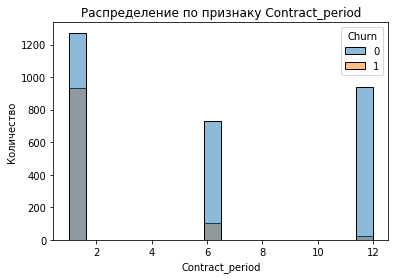

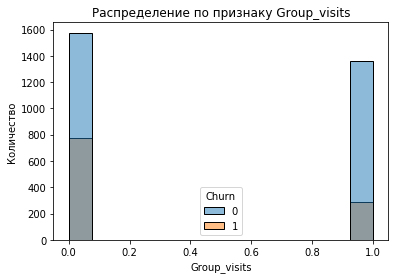

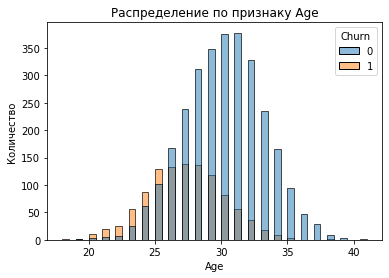

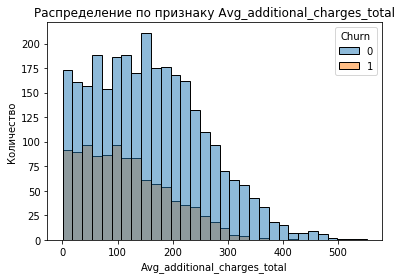

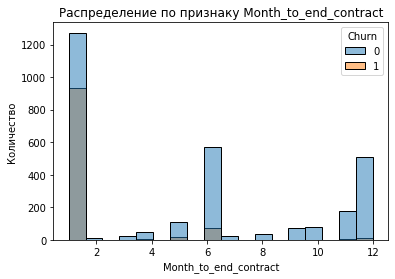

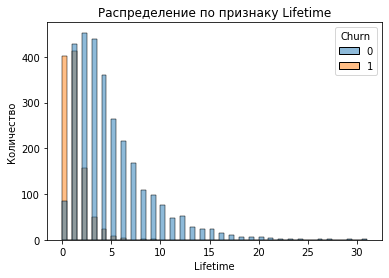

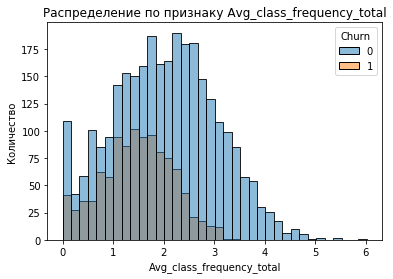

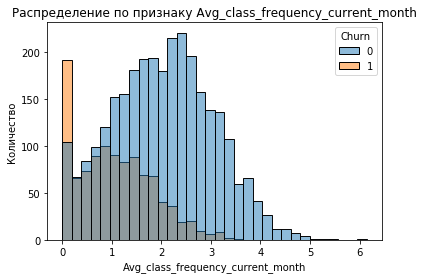

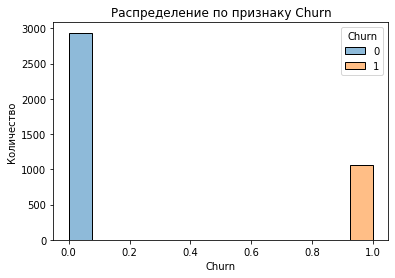

In [4]:
for column in data:
    ax = sns.histplot(data=data, 
                 x = column, 
                 hue ='Churn', 
                 alpha=0.5,
                 palette = "tab10"
                )
    ax.set_title(f'Распределение по признаку {column}')
    ax.set_ylabel('Количество')
    plt.show()

Распределение признаков на гистограммах в разрезе ушедших/оставшихся интересно проанализировать с точки зрения влияния некоторых признаков на факт ухода.

Так, например, подавляющее большинство тех, кто живет рядом с клубом, не уходят из него и исправно продолжают занятия. Стоит учитывать это.

Факт партнерства или "дружбы" с другим клиентом не оказывает особого влияния.

Длительность абонемента показывает, что те, кто берет более долгие контракты, намного реже  покидают клуб.
Групповые тренировки тоже благотворно влияют на удержание.
Распределение по возрасту говорит о том, что клиенты старше более дисциплинированы, чем молодые, но на факт возраста клиента мы не можем повлиять, поэтому не стоит учитывать этот признак.

Признаки по средним посещениям показывают, что постоянные клиенты посещают клуб чаще и больше тех, кто ушел. Это важное замечание. 

И также стоит обратить внимание на время с момента первого обращения в фитнес-центр и месяц до окончания контракта - они ярко показывают, что те, кто отваливается делают это в первый или второй месяц посещений.

## Матрица корреляций признаков. <a name="paragraph3"></a>

Взглянем за зависимость признаков.

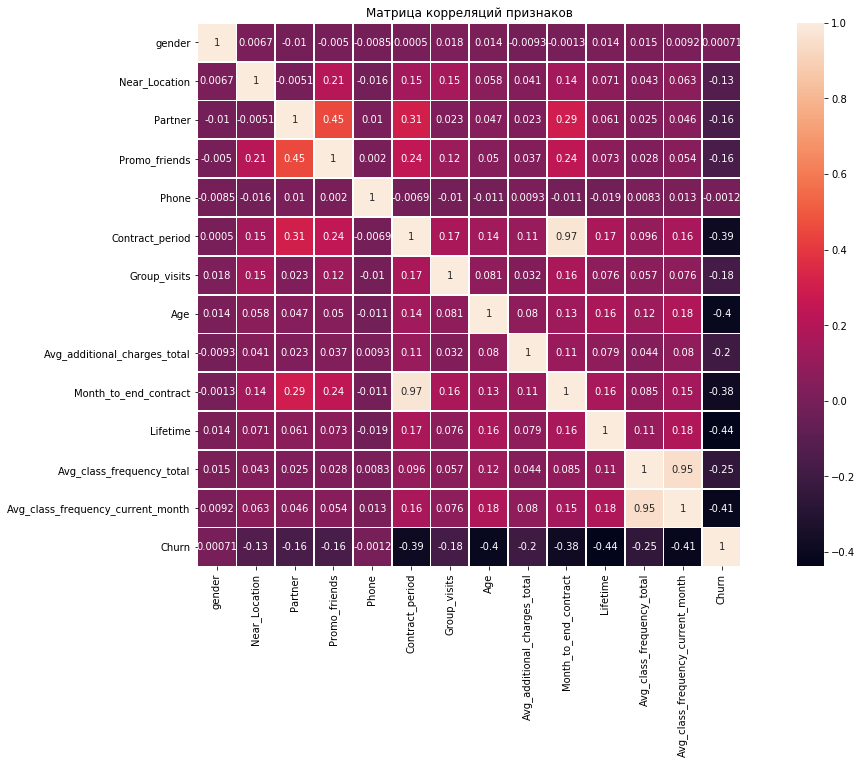

In [8]:
cm = data.corr()
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(cm, annot = True, square=True, linewidths=.8)
ax.set_title('Матрица корреляций признаков')
plt.show()

Признаки частоты посещений в среднем и за последний месяц сильно коррелируют. Необходимо один из них убрать, т.к. это может исказить модель машинного обучения. Оставим только посещения в неделю за последний месяц. 

Также сильно коррелируют длительность абонемента и месяц до окончания абонемента. Оставим признак месяца до окончания контракта.

In [5]:
data_clean2 = data.drop(['Contract_period', 'Avg_class_frequency_total'], axis = 1)

## Построение модели прогнозирования оттока клиентов <a name="paragraph4"></a>

Разбиваем данные в соотношении 80 и 20.

In [6]:
X = data_clean2.drop('Churn', axis = 1)
y = data_clean2['Churn']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Обучаем логистической регрессией

In [8]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
lr_pred = model.predict(X_test) 
lr_probas = model.predict_proba(X_test)[:,1] 

### Обучаем случайным лесом

In [9]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_probas = rf_model.predict_proba(X_test)[:, 1]

###	Оцениваем метрики accuracy, precision и recall для обеих моделей на валидационной выборке.

In [10]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy (Доля правильных ответов): {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision (Точность): {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall (Полнота): {:.2f}'.format(recall_score(y_true, y_pred)))

In [11]:
print_all_metrics(
    y_test,
    lr_pred,
    lr_probas,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy (Доля правильных ответов): 0.90
	Precision (Точность): 0.80
	Recall (Полнота): 0.79


In [12]:
print_all_metrics(
    y_test,
    rf_pred,
    rf_probas, 
    title = 'Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy (Доля правильных ответов): 0.91
	Precision (Точность): 0.83
	Recall (Полнота): 0.79


Результаты схожи. Но лучше себя проявила модель случайного леса.

## Кластеризация клиентов <a name="paragraph5"></a>

Проведем кластеризацию с целью сегментации клиентов на классы. Это поможет сформировать группы клиентов со схожим поведением и впоследствии поможет применять более индивидуальный подход к удержанию клиентов.

In [13]:
data_cut = data.drop('Churn', axis = 1) # отсечем целевую переменную, оставим только признаки

###  Стандартизация данных.

In [14]:
scaler = StandardScaler() # создаём объект класса scaler (нормализатор)
x_sc = scaler.fit_transform(data_cut) # обучаем нормализатор и преобразуем набор данных 

### Вычисляем матрицу расстояний между всеми признаками и рисуем дендрограмму

In [15]:
linked = linkage(x_sc, method = 'ward') # матрица расстояний

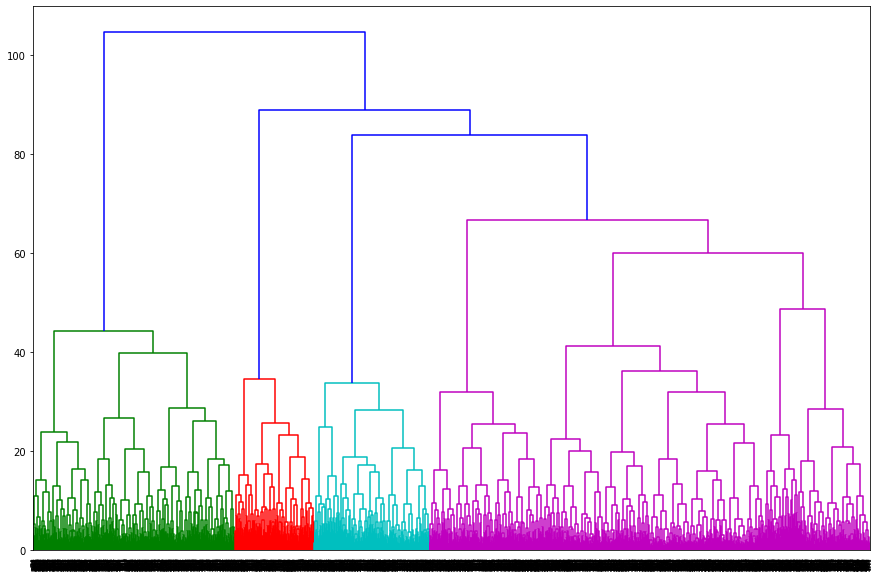

In [20]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Дендрограмма цветами предложила нам раздение на 4 кластера.

Попробуем пойти по другому пути.

### •	Кластеризация на основании алгоритма K-Means

In [16]:
km = KMeans(n_clusters = 5, random_state=0) # задаём число кластеров, равное 5
labels = km.fit_predict(x_sc)

### Cредние значения признаков для кластеров

In [17]:
data_cut['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
data_cut.groupby('cluster_km').mean().T


cluster_km,0,1,2,3,4
gender,0.502473,0.522078,0.495050,0.485737,0.560335
Near_Location,0.959446,0.862338,0.000000,1.000000,0.976105
Partner,0.783383,0.470130,0.463366,0.350238,0.356033
Promo_friends,0.574679,0.306494,0.079208,0.240095,0.229391
Phone,1.000000,0.000000,1.000000,1.000000,0.998805
Contract_period,10.884273,4.787013,2.352475,1.948494,2.665472
Group_visits,0.543027,0.425974,0.215842,0.341521,0.473118
Age,29.980218,29.301299,28.477228,28.167987,30.127838
Avg_additional_charges_total,160.706969,143.957664,135.457501,131.622204,161.724258
Month_to_end_contract,9.950544,4.475325,2.198020,1.856577,2.455197


### Распределения признаков для кластеров

In [18]:
data_cut.columns

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
       'cluster_km'],
      dtype='object')

Создам списки признаков для построения разных графиков.

In [19]:
list_1 = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits']
list_2 = ['Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month']

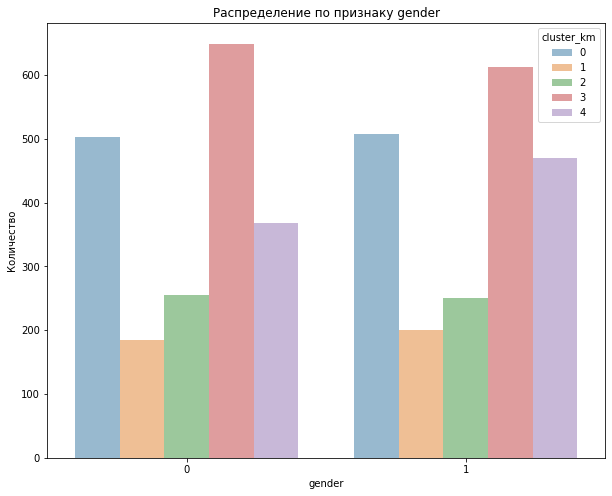

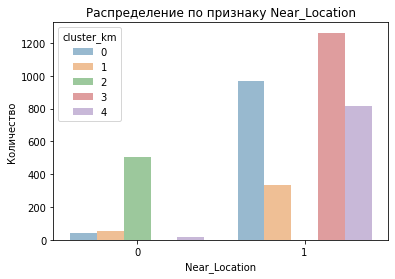

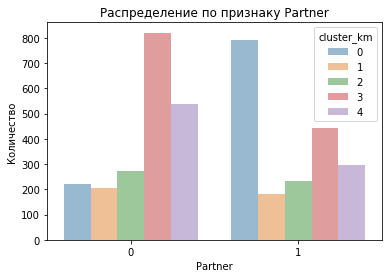

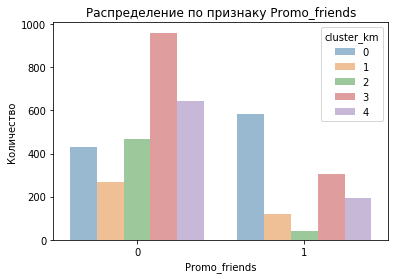

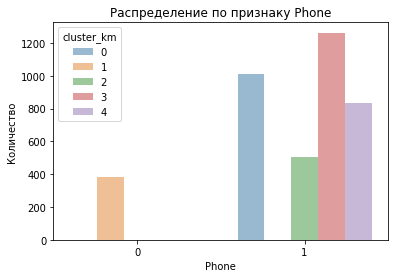

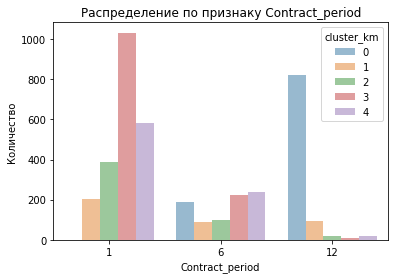

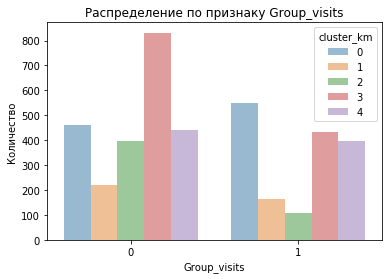

In [25]:
plt.figure(figsize=(10, 8))
for column in list_1:
    ax=sns.countplot(data=data_cut, 
                 x = column, 
                 hue = 'cluster_km', 
                 alpha=0.5,
                 palette = "tab10"
                )
    ax.set_title(f'Распределение по признаку {column}')
    ax.set_ylabel('Количество')
    plt.show()
    plt.show()

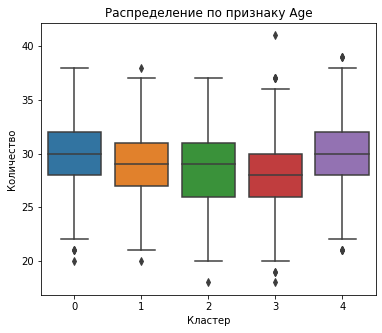

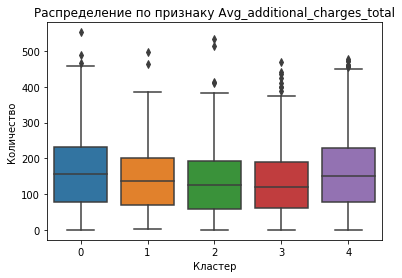

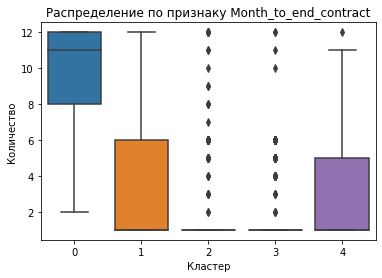

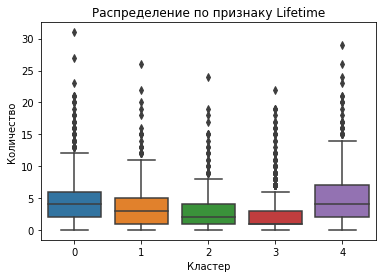

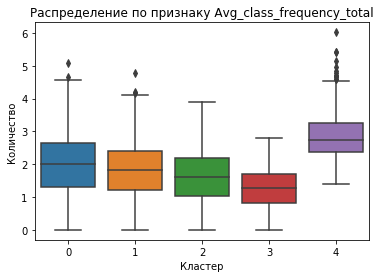

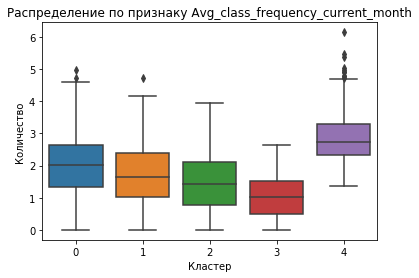

In [35]:
plt.figure(figsize=(6, 5))
for column in list_2:
    ax=sns.boxplot(data=data_cut, 
                 x = 'cluster_km', 
                 y = column,
                 palette = "tab10"
                )
    ax.set_title(f'Распределение по признаку {column}')
    ax.set_xlabel('Кластер')
    ax.set_ylabel('Количество')
    plt.show()
    plt.show()

In [36]:
data['cluster_km'] = labels

### Доля оттока по кластерам.

In [37]:
data.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
gender,0.502473,0.522078,0.495050,0.485737,0.560335
Near_Location,0.959446,0.862338,0.000000,1.000000,0.976105
Partner,0.783383,0.470130,0.463366,0.350238,0.356033
Promo_friends,0.574679,0.306494,0.079208,0.240095,0.229391
Phone,1.000000,0.000000,1.000000,1.000000,0.998805
Contract_period,10.884273,4.787013,2.352475,1.948494,2.665472
Group_visits,0.543027,0.425974,0.215842,0.341521,0.473118
Age,29.980218,29.301299,28.477228,28.167987,30.127838
Avg_additional_charges_total,160.706969,143.957664,135.457501,131.622204,161.724258
Month_to_end_contract,9.950544,4.475325,2.198020,1.856577,2.455197


Опишем полученные кластеры.

Самые надежные - это кластеры 0 и 4. Доля оттока по ним менее 10%. Самые ненадежные 2 и 3.


**0 Кластер.** Живут близко к клубу, покупают сразу длительные абонементы, посещают клуб около 2х раз в неделю, очень много клиентов пришли по партнерским акциям или по приглашению друзей.

**1 Кластер.** Берут абонементы на 1-6 месяцев. Посещают в среднем 2 раза в неделю. В целом показатели похожи на Кластер 0. Но доля оттока выше, потому что в этом кластере клиенты, которые не оставили свой номер телефона и не в курсе новостей клуба. 

**2 Кластер.** Клиенты этого кластера живут далеко от клуба. Берут короткие абонементы на 1 месяц, посещают в среднем 1,5-2 раза в неделю и отваливаются в связи с удаленностью.

**3 Кластер.** Самые молодые клиенты в этом кластере, отваливаются после первого месяца посещений. Ходят в среднем 1 раз в неделю, хотя и живут близко. Стоит пристально рассмотреть этот кластер и привлечь клиентов новыми акциями и предложениями.

**4 Кластер.** Завсегдатаи клуба. Старые клиенты, которые давно и стабильно ходят. Посещений с среднем 3 в неделю, живут поблизости. Берут короткие абонементы, но не покидают клуб несмотря на это.

## Выводы. <a name="paragraph6"></a>

В начале своего спортивного пути многие склонны к быстрому началу и к такому же быстрому концу. 
Анализ наиболее важных признаков, влияющих на отток показал, что наибольший вес имеют удаленность клуба, наличие телефона клиента, длительность контракта, средние количества посещений клуба.

Для удержания клиентов в клубе следовало бы ежемесячно отслеживать частоту посещений клуба, в случае резкого начала и резкого конца, необходимо поощрить клиента бесплатной тренировкой или значительной скидкой на случай возвращения. Бесплатная тренировка даст возможность проанализировать ошибки резкого старта с профессионалом и скорректировать программу на длительный срок.

Обязательно отслеживать наличие номера телефона в анкете клиента. 

Активно рекламировать клуб в районе, где тот находится. Сюдя по данным, много постоянных посетителей среди тех, кто живет или работает поблизости.

Для новых клиентов есть смысл предлагать также скидки на занятия с тренером или бонусные групповые тренировки, которые помогут комфортно влиться в фитнес и не разочароваться на ранних этапах.